# Imports

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../fastai/') #fastai version 1.0

from fastai.vision import *

import pandas as pd
import numpy as np
import os
import torch
import torchvision
from torchsummary import summary
from pathlib import Path
from functools import partial, update_wrapper
from tqdm import tqdm_notebook as tqdm

PATH = Path('/home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection')
TRAIN_NAME = 'train'
TRAIN = PATH/TRAIN_NAME
CSV_NAME = 'train_labels.csv'
LABELS = PATH/CSV_NAME
TEST_NAME = 'test'
TEST = PATH/TEST_NAME
SAMPLE = PATH/'sample_submission.csv'
SUBMISSIONS = PATH/'submissions'
SUBMISSIONS.mkdir(exist_ok=True)

nw = 16   #number of workers for data loader
torch.cuda.set_device(0)
torch.backends.cudnn.benchmark=True
np.random.seed(42)

sz = 96
bs = 64

# Data 

In [2]:
data = (ImageItemList.from_csv(path=PATH, csv_name=CSV_NAME, folder=TRAIN_NAME, suffix='.tif')
.random_split_by_pct(0.2)
.label_from_df()
.add_test_folder(test_folder=TEST_NAME, label=None)
.transform(get_transforms(flip_vert=True), size=sz)
.databunch(bs=bs, num_workers=nw)
.normalize(imagenet_stats))

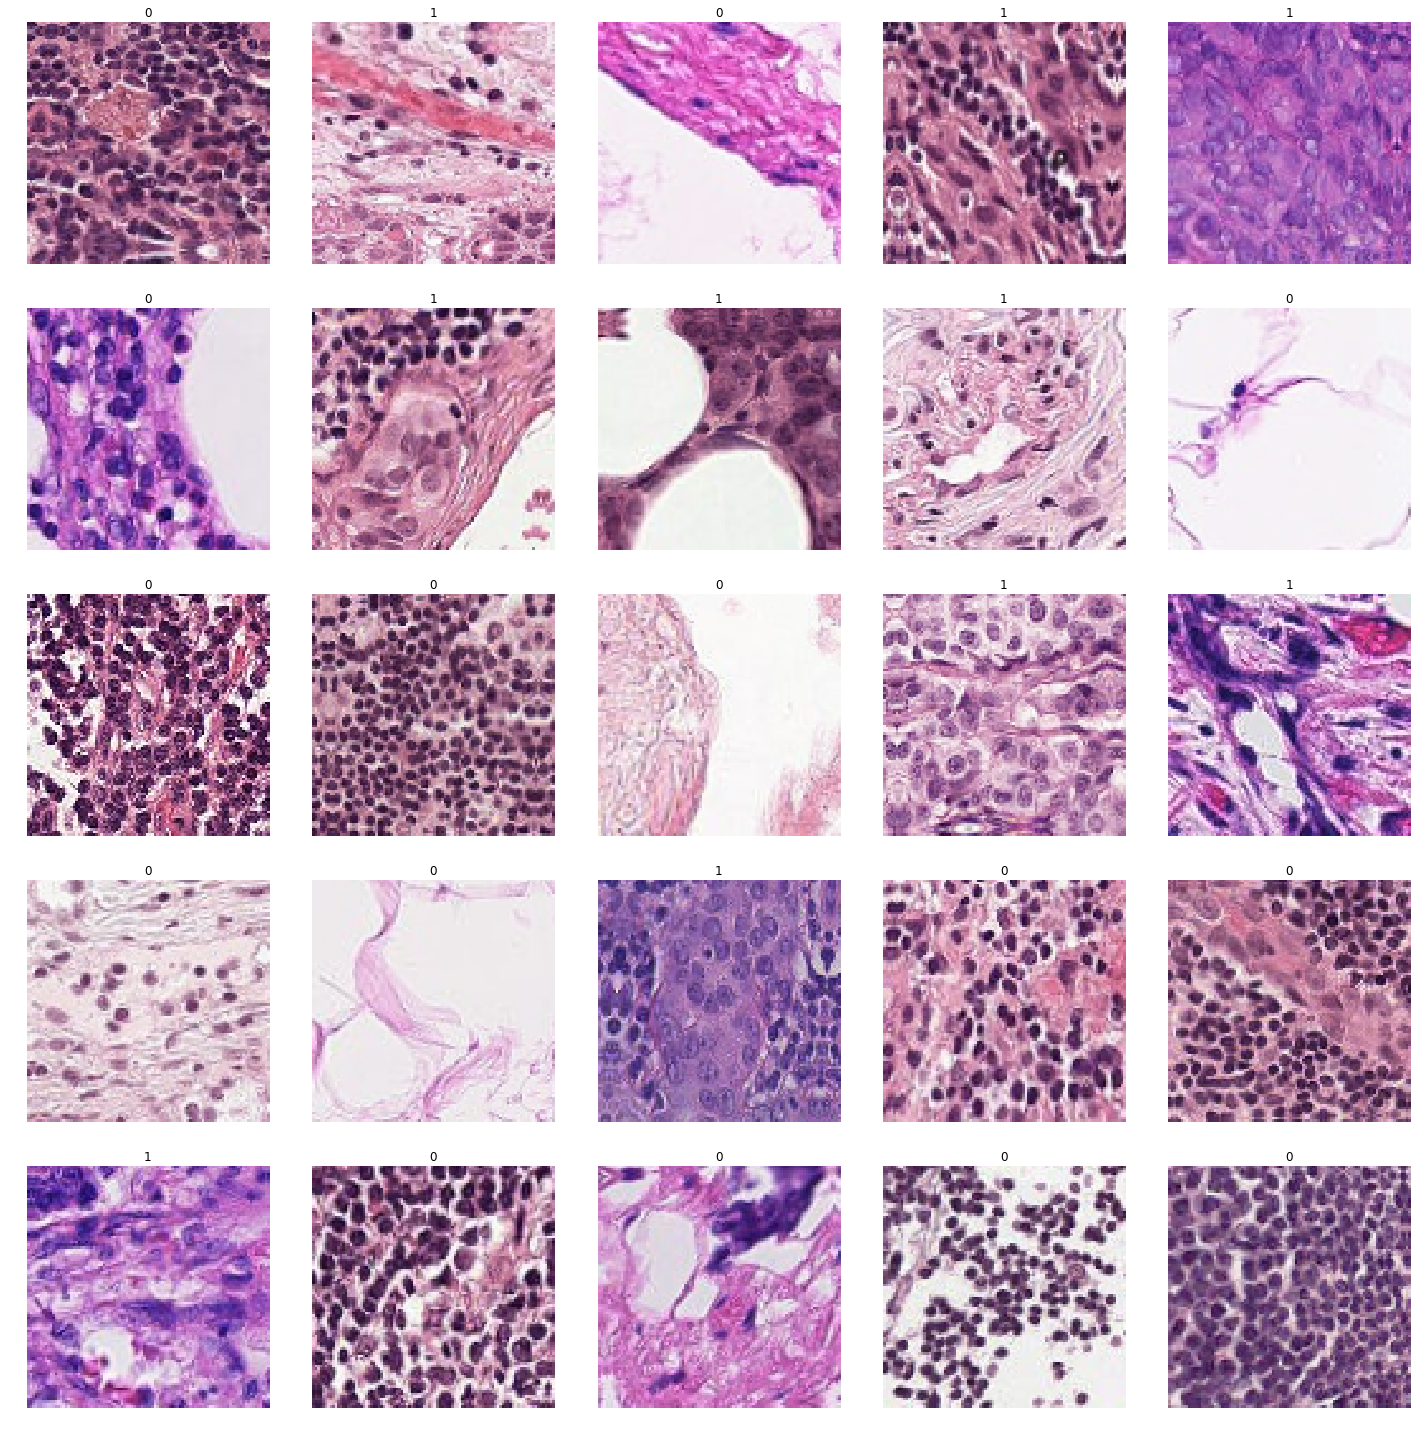

In [3]:
data.show_batch()

# Train

In [6]:
arch = torchvision.models.resnet50

In [7]:
learner = create_cnn(data=data, 
                     arch=arch, 
                     loss_func=torch.nn.CrossEntropyLoss(),
                     metrics=[accuracy])

In [10]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


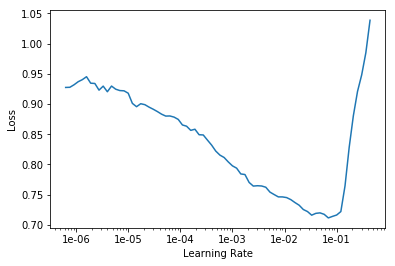

In [11]:
learner.recorder.plot()

In [12]:
lr = 1e-2

In [ ]:
learner.fit_one_cycle(8, slice(lr))

epoch,train_loss,valid_loss,accuracy
1,0.267814,0.224911,0.912896


In [ ]:
learner.save('resnet50_cycle_len=8-head')

In [ ]:
learner.unfreeze()

In [ ]:
learner.lr_find()

In [ ]:
learner.recorder.plot()

In [18]:
learner.fit_one_cycle(20, slice(xxx, lr/5))

epoch,train_loss,valid_loss,accuracy
1,0.179290,0.148036,0.945188


In [19]:
learner.save('resnet50_cycle_len=20-complete'')

# Interpretation

In [22]:
interp = ClassificationInterpretation.from_learner(learner)

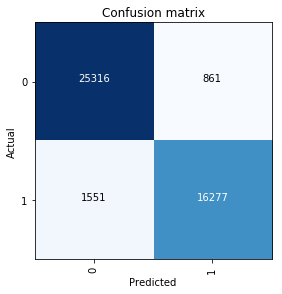

In [25]:
interp.plot_confusion_matrix()

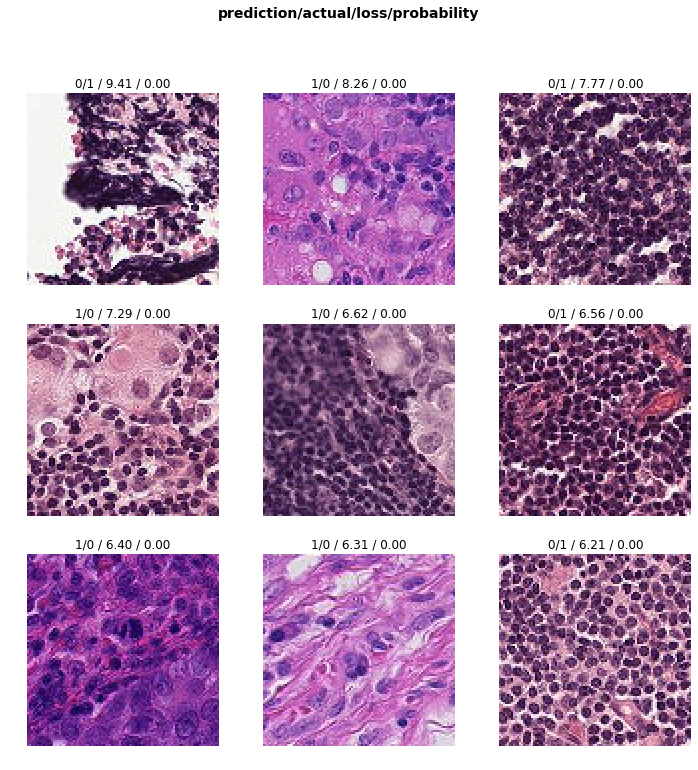

In [27]:
interp.plot_top_losses(9)

# Predictions

In [53]:
preds, _ = learner.get_preds(DatasetType.Test)

In [47]:
pred_labels = []
for p in tqdm(np.array(preds)):
    if p[0] > p[1]:
        pred_labels.append(0)
    if p[0] < p[1]:
        pred_labels.append(1)
    if p[0] == p[1]:
        pred_labels.append(1)
        print('same')

In [79]:
df = pd.DataFrame({'id':[fname.split('.')[0] for fname in os.listdir(TEST)], 'label':pred_labels})

In [ ]:
name = f'{arch.__name__}_sz{sz}_bs{bs}-2'

In [81]:
df.to_csv(SUBMISSIONS/name, header=True, index=False)